# 一切都是套路

In [1]:
#!/usr/bin/env python
#coding=utf-8
import sys
from IPython.display import Image


import os,sys
import numpy as np
import random
import codecs
import torch as t
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable


is_cuda = t.cuda.is_available()

In [2]:
import re
html_tag= re.compile(r'<[^>]+>')
def remove_tags(text):
    return html_tag.sub('', text)

In [3]:
corpus=[]
with codecs.open('news1.txt', 'r', 'utf-8') as f:
    corpus = list(''.join(f.readlines()))
print('total chars:{0}'.format(len(corpus)))

total chars:1419584


In [4]:
n_seqs, n_steps = 64, 32
vocabs = sorted(list(set(''.join(corpus))))
print('vocabs:{}'.format(len(vocabs)))
idx2char= {i: w for i, w in enumerate(vocabs)}
char2idx = {w: i for i, w in enumerate(vocabs)}


vocabs:3545


In [5]:
curr_idx = 0
text=corpus[curr_idx:curr_idx+n_seqs* n_steps*100]

encoded = np.array([char2idx[ch] for ch in text])
def one_hot_encode(arr, n_labels):
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    return one_hot


def get_batches(arr, n_seqs, n_steps):
    '''Create a generator that returns mini-batches of size
       n_seqs x n_steps from arr.
    '''
    batch_size = n_seqs * n_steps
    n_batches = len(arr)//batch_size
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size]
    # Reshape into n_seqs rows
    arr = arr.reshape((n_seqs, -1))
    
    for n in range(0, arr.shape[1], n_steps):
        # The features
        x = arr[:, n:n+n_steps]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+n_steps]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y
        


## Focal Loss 让深度学习不再柿子挑软的吃

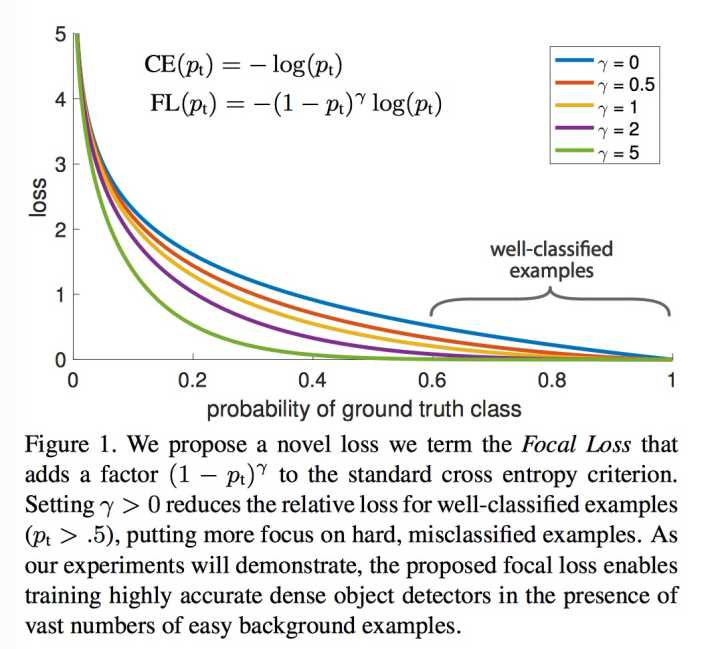

In [6]:
Image(filename='focalloss.jpg')

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float)): self.alpha = t.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = t.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

## Pull-away term Loss   让深度学习从此喜欢多变

In [8]:
def pullaway_loss(embeddings):
    norm = t.sqrt(t.sum(embeddings ** 2.0, 1, keepdim=True))
    normalized_embeddings = embeddings / norm
    similarity = t.matmul(normalized_embeddings, normalized_embeddings.transpose(1, 0))
    batch_size = embeddings.size()[0]
    pt_loss = (t.sum(similarity) - batch_size) / (batch_size * (batch_size - 1))
    return pt_loss




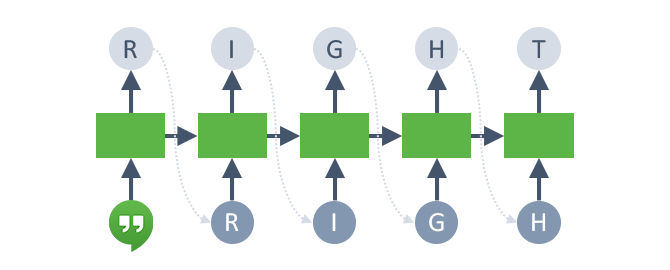

In [9]:
Image(filename='charrnn.png')

In [20]:
class CharRNN(nn.Module):
    def __init__(self, vocabs, n_steps=100, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        self.vocabs = vocabs
        self.idx2char = dict(enumerate(self.vocabs))
        self.char2idx = {ch: ii for ii, ch in self.idx2char.items()}
        
        self.dropout = nn.Dropout(drop_prob)
        self.lstm = nn.LSTM(len(self.vocabs), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        self.fc = nn.Linear(n_hidden, len(self.vocabs))
        
        self.init_weights()
        
    def forward(self, x, hc):
        x, (h, c) = self.lstm(x, hc)
        x = self.dropout(x)
        
        x = x.view(x.size()[0]*x.size()[1], self.n_hidden)
        
        x = self.fc(x)
        
        return x, (h, c)
    
    def predict(self, char, h=None, cuda=False, top_k=None):
        ''' 输入一个字去预测下一个字
            回传预测的字以及隐状态
        '''
        if cuda:
            self.cuda()
        else:
            self.cpu()
        
        if h is None:
            h = self.init_hidden(1)
        
        x = np.array([[self.char2idx[char]]])
        x = one_hot_encode(x, len(self.vocabs))
        inputs = Variable(t.from_numpy(x), volatile=True)
        if cuda:
            inputs = inputs.cuda()
        
        h = tuple([Variable(each.data, volatile=True) for each in h])
        out, h = self.forward(inputs, h)

        p = F.softmax(out, dim=1).data
        if cuda:
            p = p.cpu()
        
        if top_k is None:
            top_ch = np.arange(len(self.vocabs))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
            
        return self.idx2char[char], h
    
    def init_weights(self):
        ''' 初始化权重'''
        initrange = 0.1
        
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-1, 1)
        
    def init_hidden(self, n_seqs):
        weight = next(self.parameters()).data
        return (Variable(weight.new(self.n_layers, n_seqs, self.n_hidden).zero_()),
                Variable(weight.new(self.n_layers, n_seqs, self.n_hidden).zero_()))

In [21]:
companies=['格力','科大讯飞','平安银行','神州高铁','东阿阿胶','苏宁环球','云南白药','五粮液','金螳螂','海康威视']

def write_something(net, size=200, prime='马云', top_k=5):
    if is_cuda:
        net.cuda()
    else:
        net.cpu()

    net.eval()

    #首先先输入提示词
    words = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = net.predict(ch, h, cuda=False, top_k=top_k)

    words.append(char)

    # 在把每次結果逐一當作輸入再投入
    for ii in range(size):
        char, h = net.predict(words[-1], h, cuda=False, top_k=top_k)
        words.append(char)

    return ''.join(words)


In [22]:
def train(net, data, epochs=100, n_seqs=64, n_steps=32, lr=0.001, clip=5, val_frac=0.1, cuda=False, print_every=10):
    global companies
    ''' Traing a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        n_seqs: Number of mini-sequences per mini-batch, aka batch size
        n_steps: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        cuda: Train with CUDA on a GPU
        print_every:每隔几次打印一回训练中间状态
    
    '''
    net.train()
    opt = t.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if cuda:
        net.cuda()
    
    counter = 0
    n_chars = len(net.vocabs)
    for e in range(epochs):
        h = net.init_hidden(n_seqs)
        for x, y in get_batches(data, n_seqs, n_steps):
            counter += 1
            
            #  One-hot 将语料转换为pytorch张量
            x = one_hot_encode(x, n_chars)
            x, y = t.from_numpy(x), t.from_numpy(np.int64(y))
            
            inputs, targets = Variable(x), Variable(y)
            if cuda:
                inputs, targets = inputs.cuda(), targets.cuda()

            h = tuple([Variable(each.data) for each in h])

            net.zero_grad()
            
            output, h = net.forward(inputs, h)

            loss = criterion(output, targets.view(n_seqs*n_steps))+FocalLoss(gamma=2)(output, targets.view(n_seqs*n_steps))+0.1*pullaway_loss(output)
                

            loss.backward()
            
            # 透过梯度截断机制可以避免梯度爆炸.
            nn.utils.clip_grad_norm(net.parameters(), clip)

            opt.step()
            if counter % 2*print_every == 0:
                t.save(net.state_dict(),'Models/CharRnn.rnn')
            if counter % print_every == 0:
                t.save(net.state_dict(),'Models/CharRnn_{0}.rnn'.format(e))
                t.save(net.state_dict(),'Models/CharRnn.rnn')
                # Get validation loss
                val_h = net.init_hidden(n_seqs)
                val_losses = []
                for x, y in get_batches(val_data, n_seqs, n_steps):
                    # One-hot 将语料转换为pytorch张量
                    x = one_hot_encode(x, n_chars)
                    x, y = t.from_numpy(x), t.from_numpy(np.int64(y))
                    
                    # 为隐藏状态设计独立变量，以简化计算流程
                    val_h = tuple([Variable(each.data, volatile=True) for each in val_h])
                    
                    inputs, targets = Variable(x, volatile=True), Variable(y, volatile=True)
                    if cuda:
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net.forward(inputs, val_h)
                    val_loss = criterion(output, targets.view(n_seqs*n_steps))+FocalLoss(gamma=2)(output, targets.view(n_seqs*n_steps))+0.1*pullaway_loss(output)
                
                    val_losses.append(val_loss.data[0])
                    
                #打印模型训练中间状态
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.data[0]),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))
                print(write_something(net, 500, prime=random.choice(companies), top_k=5))


In [23]:
if 'net' in locals():
    del net

In [24]:
net = CharRNN(vocabs, n_hidden=512, n_layers=2)
#若是模型已经存在则还原
if os.path.exists('Models/CharRnn.rnn'):
    net.load_state_dict(t.load('Models/CharRnn.rnn'))
    print('模型已经加载复原')

In [25]:
n_seqs, n_steps = 32, 64
n_batches=100

 #只是单纯先设定一个够大可以容纳下训练数据，但又不会大到把内存用尽的大小
train(net, encoded, epochs=25, n_seqs=n_seqs, n_steps=n_steps, lr=0.001, cuda=False, print_every=10)

Epoch: 1/25... Step: 10... Loss: 13.1996... Val Loss: 15.7990
五粮液000011282050000500005600200000808055558001002088105060020000050022015100000050000082806000000200001000666580815000020800001605800501580651050500166650008851000000000000500005688051080000800000006065060000000002000008000000050005000000085000000020008800005805005051005080000025001500656100005501000500802601600000800505005551001200000500802150856000200000000000200506610018608102880000225010000018000586658001000202000800016580100000000060000000050068000560056055601000220800808005680002000002500000500
Epoch: 1/25... Step: 20... Loss: 11.4861... Val Loss: 13.7395
神州高铁0112220100000023200010002001310,,20,223022,020,,000223011202000,2020,230003000,31232,030203200000,0,,2333220330330,013,200,0,33200023000000300,030,231200022230003002232,13,0,0,00,03380230,330000,132010000201033,,000,012030220303300020020023,32022020,033,0301002001,0321,,3002,1023232030300033300,0321,03112,11,00128003,3,2030020022001,3,103032,310300022201111033,2013

Epoch: 2/25... Step: 160... Loss: 8.1855... Val Loss: 11.5294
科大讯飞，1240151.41150.615%，1.11504.102021.115%，21.500201.0101.590015.400126000005150115151.4100015036061514.0150000000037股股份(699,5805101554.15211000203100061051.6002015.11032.1001.012.00125.0151.4202105.SZ中证券00200000015660015,760002271.0110010100.1610011400060760101031,6025,4576601500000000300360605771.10200010.501001.58%)，证券.20%，20.01051.06611.50%114000051001143,300211540161611,7791,102011,5461,5571401000500036676115,47179,179111,989,1959,9519,991,9205144,30221,140015014,969,797,109,5120,99591500002001
Epoch: 2/25... Step: 170... Loss: 8.2482... Val Loss: 11.3424
东阿阿胶02020005年))证券(263348))融券(0003600493)金(6030443)(0001454)(0030000000003800000363080068048930020189084600360036900363006360048366001500406006000030686000136403600259S))(000188.8S))(038.8%-4.8%-360.20%；中国国证券持(0032001044年(3020155)SZ证券03600000000002000000300300360006390001064036010159)366003603))证券(03001436030201046000360004636330039901396.690%。1430320030003993038900000

Epoch: 4/25... Step: 310... Loss: 6.6931... Val Loss: 10.5702
苏宁环球40.001010360013010415020360400400140160016013034011404010160103611400401004040303880815,00203,404,331615,0046,6002,0002,2111,4042,280,0401,01014,1000011400033000104030030214年业绩1001040036014036004130,01621515,4063104,336,266111,402,101001,0032,6810150040000360415040036,00010000140200143,32221,504,263401,000021043003602414海航空2,386,1532,652,1331,60002,10043,66020,5900213,40032000150400020241002601404036011014030002815海通科技381,40,466133,436,336431,402,02330,100020150403660483大华瑞华414,30,6632414,300152,
Epoch: 4/25... Step: 320... Loss: 6.3286... Val Loss: 10.4132
东阿阿胶100033001503360136836.50310.5100000381.SH中国银行5.1520.6130.503.00013801.100201533.000150.0320.5330.361.00120.2500000301030002010502610001530.0150035004336008838.0130.11002015040036333088035004000000001800015030361150.550003368.SHK中国北电3.353400.95003600883中海南电0211,503,991151,493,31411,590,3921114043.0000028504360036837中科科技14153,80313,889,1191,193,888133,99020020330016

Epoch: 6/25... Step: 460... Loss: 5.3776... Val Loss: 10.4728
五粮液49002450004035000533404346304001600150004016040460140100406600855,401459,9581,5041,0000195040360400350401600406804886,90844,4891,55141,7791,18140,40000050050360115404330028194家业公100,990,68419,095,1951,1999,98911,97420001284000062045040040140485000400458661504005304003540053433600496,364129,804,41599,580,451195,7901,4814,405140,50225,5522150403600468天信息199,649,998199,879,49159,991,9559,0194,9005241504030610860456,98049,991115,478101,0154101,9000015044000002265华电子115,947,49449,0000,07011,971,01802,
Epoch: 6/25... Step: 470... Loss: 5.1423... Val Loss: 10.5646
神州高铁：公布首次会主要利润资产券化注册制，因为国家银行之一，已经取商务部部门的年期投资，有不足。公务员跳槽至个人位和职位，年以来看到多的个位层次，目前，已经取得到了。随外消费、生产能和运行等优势，同时下降。同时，以公司为基本与资产质量将有效率和一季度，同时为公司为基本每股派息差表现不良贷款，但同时也将会到2013年第四季度实现营销量2139.99亿元，比较年增10.4%，环比下滑。 13 个股点，我们调整和一个股转，目前已有望实施，这一个股将有限公司。”以来看，一个人选择为基金信贷额度，同时，在全国会有运作，国内多部门相关机构，以资产证券化注册制，加速提高端产品化，不能有限于公司在去年实现净利润为135.5亿，元。公司为211年年报期至3315 年，公司将以更为基金的投资者可能力，不足，我们认为，这一一个级以来，一个高管理层以及资

KeyboardInterrupt: 